<a href="https://colab.research.google.com/github/nnswa/Hand-Gestur-Recognition/blob/main/Coba_1_Deteksi_Gestur_SVM_(dataset_1_subjek%2C_lowpass).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import scipy.signal as signal
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score

In [ ]:
# Load and preprocess data
df=pd.read_csv('/content/drive/MyDrive/SKRIPSII/CODE PROGRAM/COBA/EMG-data.csv/niswa_class_subject_fix3.csv')
# df.drop('label',inplace=True,axis=1)
df.head()

,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,label
0,254,214,111,156,250,214,250,12,0,1
1,250,140,250,214,250,214,250,128,0,1
2,250,246,231,140,250,246,250,214,0,1
3,243,214,254,28,250,12,250,214,0,1
4,231,246,227,162,248,210,57,62,0,1


In [ ]:
df['class'].value_counts()

,count
class,
1,77
0,76
5,64
6,64
8,64
7,63
9,63
3,62
2,51


In [ ]:
len(df['label'].value_counts())

1

In [ ]:
# Group data by subject label and class
subjects_data=df.groupby(['label','class'])

Filtering

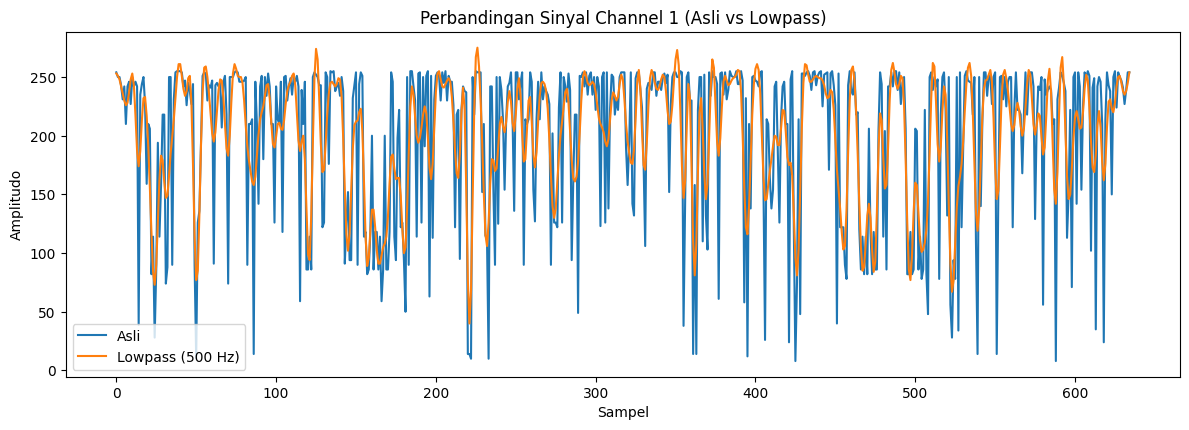

In [ ]:
# Pisahkan data fitur (channel1-channel8) dan target (class)
X_raw = df.iloc[:, :-2].values  # Semua kolom channel (channel1 - channel8)
y = df['class'].values  # Mengambil kolom 'class' sebagai target

fs = 3000

"""# Desain filter bandpass (sesuaikan frekuensi cutoff)
lowcut = 20  # Frekuensi cutoff bawah
highcut = 500  # Frekuensi cutoff atas
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist

# Gunakan Butterworth filter orde 4
b, a = signal.butter(4, [low, high], 'bandpass')

# Menerapkan filter bandpass ke setiap channel
filtered_data = np.zeros_like(X_raw)
for i in range(X_raw.shape[1]):
    filtered_data[:, i] = signal.filtfilt(b, a, X_raw[:, i])

# Desain filter notch (sesuaikan frekuensi notch)
notch_freq = 50  # Frekuensi notch (50 Hz untuk noise listrik)
quality_factor = 35  # Faktor kualitas untuk filter notch
b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, fs)

# Menerapkan filter notch ke setiap channel
filtered_data_notch = np.zeros_like(filtered_data)
for i in range(filtered_data.shape[1]):
    filtered_data_notch[:, i] = signal.filtfilt(b_notch, a_notch, filtered_data[:, i])


# Visualisasi sinyal asli, setelah bandpass, dan bandpass + notch
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(X_raw[:, 0], label='Asli')
plt.plot(filtered_data[:, 0], label='Bandpass')
plt.plot(filtered_data_notch[:, 0], label='Bandpass + Notch')
plt.legend()
plt.xlabel('Sampel')
plt.ylabel('Amplitudo')
plt.title('Perbandingan Sinyal Channel 1 (Asli, Bandpass, Bandpass + Notch)')

plt.tight_layout()
plt.show()"""

# Desain filter lowpass (frekuensi cutoff)
lowcut = 500  # Frekuensi cutoff atas (500 Hz)
nyquist = 0.5 * fs
low = lowcut / nyquist

# Gunakan Butterworth filter orde 4 untuk lowpass
b_lowpass, a_lowpass = signal.butter(4, low, 'low')

# Menerapkan filter lowpass ke setiap channel
filtered_data_lowpass = np.zeros_like(X_raw)
for i in range(X_raw.shape[1]):
    filtered_data_lowpass[:, i] = signal.filtfilt(b_lowpass, a_lowpass, X_raw[:, i])

# Visualisasi hasil filtering lowpass
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(X_raw[:, 0], label='Asli')
plt.plot(filtered_data_lowpass[:, 0], label='Lowpass (500 Hz)')
plt.legend()
plt.xlabel('Sampel')
plt.ylabel('Amplitudo')
plt.title('Perbandingan Sinyal Channel 1 (Asli vs Lowpass)')
plt.tight_layout()
plt.show()


In [ ]:
# Feature extraction functions
import numpy as np

def rms(data): #root mean square
      return  np.sqrt(np.mean(data**2,axis=0))

In [ ]:
# Menghitung RMS untuk setiap channel di tiap kelas (referensi)
start=time()
rms_features=subjects_data.agg([ 'min','max',np.ptp,rms])

end=time()
print('feature calculation time of one subject one class')
print((end-start)/(1*9))

features=rms_features.reset_index()
features.head()

feature calculation time of one subject one class
0.009054104487101236


label class channel1                       channel2                        \
                   min  max  ptp         rms      min  max  ptp         rms   
0     1     0       10  255  245  216.507506        8  255  247  203.067755   
1     1     1       14  255  241  215.325667       14  255  241  188.647097   
2     1     2       50  255  205  183.013661       74  255  181  204.761315   
3     1     3       10  255  245  210.911922       24  255  231  223.677980   
4     1     4       49  254  205  220.148301       26  255  229  209.205359   

   ... channel6             channel7                       channel8            \
   ...      ptp         rms      min  max  ptp         rms      min  max  ptp   
0  ...      243  200.389259       24  255  231  213.473898       12  255  243   
1  ...      231  196.489780       18  255  237  215.716505       12  255  243   
2  ...      179  183.848936       43  255  212  199.288145       40  255  215   
3  ...      229  225.365975        8  255  247  219.261811        8  255  247   
4  ...      229  209.128022       10  255  245  217.325770       10  255  245   

               
          rms  
0  202.518193  
1  195.970512  
2  187.501843  
3  211.996690  
4  211.287139  

[5 rows x 34 columns]

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Membagi data menjadi data pelatihan dan data pengujian
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.1, random_state=42)

# Membuat pipeline untuk SVM
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=6.0, gamma=0.04))

# Melatih model
svm_model.fit(X_train, y_train)

# Melakukan prediksi pada data pengujian
y_pred = svm_model.predict(X_test)

# Menghitung dan mencetak akurasi dan laporan klasifikasi
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi:", accuracy)
print("Laporan Klasifikasi:\n", classification_report(y_test, y_pred))

Akurasi: 0.1875
Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.38      0.38      0.38         8
           2       0.00      0.00      0.00         4
           3       0.33      0.50      0.40         8
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         3
           6       0.25      0.09      0.13        11
           7       0.33      0.40      0.36         5
           8       0.40      0.33      0.36         6
           9       0.00      0.00      0.00         7

    accuracy                           0.19        64
   macro avg       0.17      0.17      0.16        64
weighted avg       0.20      0.19      0.18        64



Akurasi: 18.75%
F1 Score: 0.16


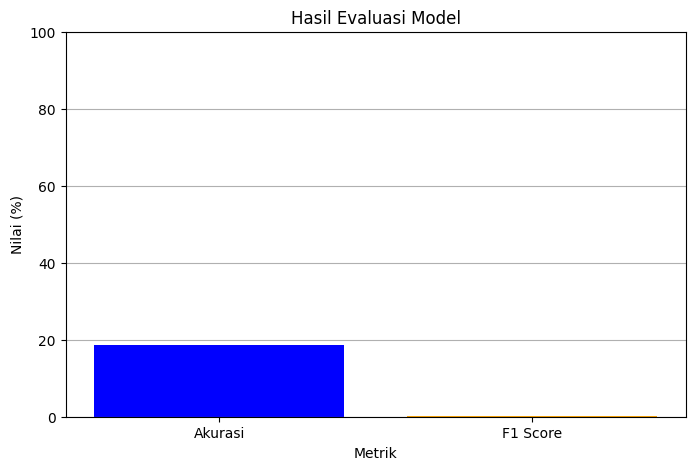

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

# Mencetak hasil evaluasi
print(f'Akurasi: {accuracy * 100:.2f}%')
print(f'F1 Score: {f1:.2f}')

# Membuat DataFrame untuk hasil
results_df = pd.DataFrame({
    'Metric': ['Akurasi', 'F1 Score'],
    'Score': [accuracy * 100, f1]
})

# Membuat diagram batang
plt.figure(figsize=(8, 5))
plt.bar(results_df['Metric'], results_df['Score'], color=['blue', 'orange'])
plt.ylim(0, 100)  # Mengatur batas y dari 0 hingga 100 untuk akurasi
plt.title('Hasil Evaluasi Model')
plt.xlabel('Metrik')
plt.ylabel('Nilai (%)')
plt.grid(axis='y')

# Menampilkan diagram batang
plt.show()


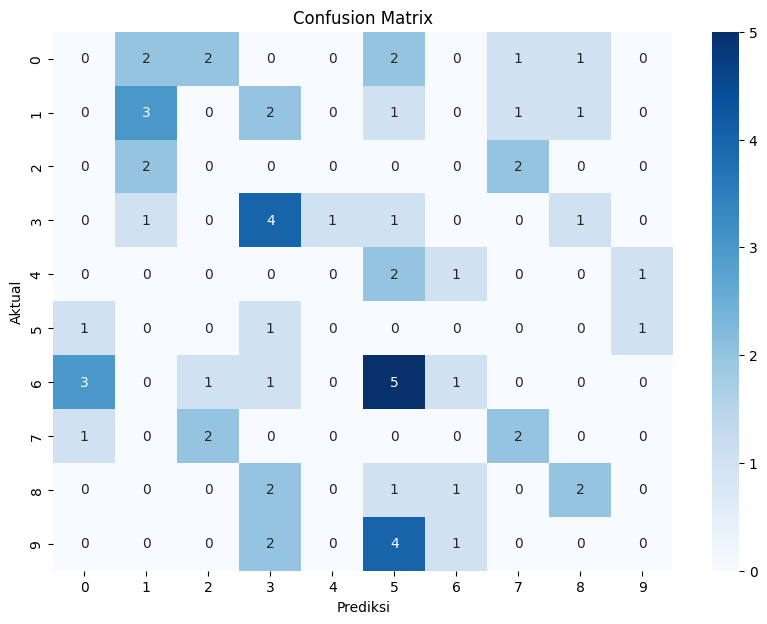

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Menghitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Menentukan jumlah kelas secara otomatis
num_classes = len(np.unique(y_test))

# Membuat heatmap dari confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()